# <div align="center">CM5</div>

## 5.1 Importing libraries

In [1]:
# Handle table-like data and matrices :
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# Modelling Helpers Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

# Deep Learning Libraries
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# Resnet 
import keras
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.regularizers import l2
from keras.models import Model
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Machine Learning Model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Time library
import time 


# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
import itertools

/kaggle/input/fashionmnist/fashion_mnist_dataset_train.npy


## 5.2 Dataset Extract 

In [2]:
data = np.load('../input/fashionmnist/fashion_mnist_dataset_train.npy', allow_pickle=True).item()
data = np.array(data)
my_dict = data[()]
features = my_dict.get('features')
target = my_dict.get('target')
farray = features.reshape(features.shape[0], (features.shape[1]*features.shape[2]))
column_names = []
[column_names.append("pixel"+str(x)) for x in range(0, 784)]
f1 = pd.DataFrame(farray , columns = column_names)
column_names = ['target']
t1  = pd.DataFrame(target , columns = column_names)
f1['target'] = t1['target'] - 1
f1.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,target
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.3 Dataset visualization

In [3]:
clothing2 = {0 : '1',
            1 : '2',
            2 : '3',
            3 : '4',
            4 : '5'}

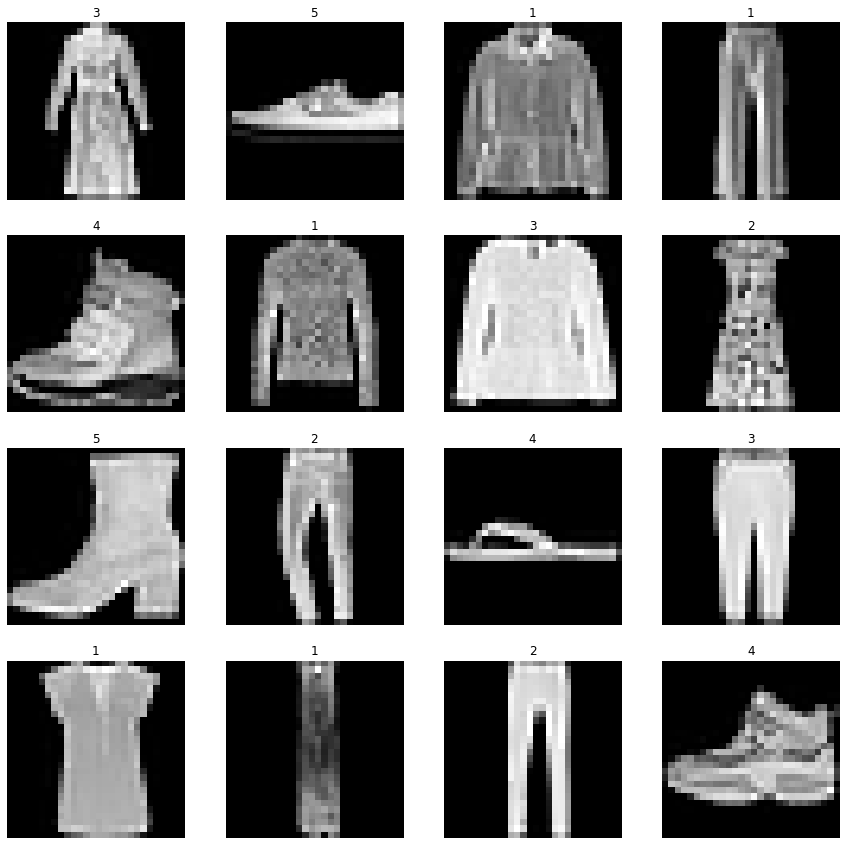

In [4]:
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = f1.drop('target', axis=1).values[index].reshape(28,28)
        cloths = f1['target'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing2[cloths])
        axe.set_axis_off()

## 5.3 Data Preprocessing

### 5.3.1 Setting Random Seeds for Reproducibilty :

In [5]:
seed = 66
np.random.seed(seed)

### 5.3.2 Splitting Data into Train and Validation Set :

In [6]:
X = f1.iloc[:, :-1]
Y = f1.iloc[:,784]
x_train1, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.2, random_state=seed)
x_val1,x_test1,y_val,y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=seed)

### 5.3.3 Reshaping Image :

In [7]:
x_train = x_train1.values.reshape((-1, 28, 28, 1))
x_val = x_val1.values.reshape((-1, 28, 28, 1))
x_test = x_test1.values.reshape((-1, 28, 28, 1))

### 5.3.4 One Hot Encoding :

In [8]:
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

## 5.4 Convolutional Neural Network :


### 5.4.1 The design of Convolution neural networks definition :

1) Firstly we used **Sequential Keras API** which is just a linear stack of layers.

2) Then we include **Convolutional Layers**, this operation performs below operations :

    1. Apply filters to extract features.

    2. Apply activation function( in our case 'relu' ) on every every input value of feature maps.

    3. Filters are composed of small kernels learned.

3) Next we apply **Batch Normalization** to achieve zero mean and zero variance on image pixels after each convolution.

4) Then we add **Max Pooling Layers**, which are used for Dimensionality Reduction or DownSampling the Input. These are used where we have lot of Input Features. It reduces the amount of Parameters and Computational power required drastically, thus reducing Overfitting. These along with Convolutional layers are able to learn more Complex features of the Image.

5) We add **Dropout Layers** to avoid Overfitting. DropOut is a Regularization Technique, which Penalizes the Parameters. We DropOutRate to 0.25. Usually in general we can set this rate between 0.2-0.5.

6) Then we include **Flatten layer** to map the input to a 1D vector. We then add Fully connected Layers after some convolutional/pooling layers.

7) Lastly, we add the **Dense (Output) Layer**. It has units equal to the number of classes to be identified.Here, we use 'softmax' function since it is Multi-Class Classification. For binary classification we can use 'sigmoid' function.

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

### 5.4.2 Optimizer of the model :

- Before model compilation we need to set optimizer used by the model. We have multiple options for optimizer e.g ADAM, SGD, ADAGRAD, ADADELTA, RMSPROP.

**Parameters for Adam optimizer:**

- learning rate : the learning rate is a configurable hyperparameter used in the training of neural networks. The learning rate controls how quickly the model is adapted to the problem.

- beta1 : The exponential decay rate for the first moment estimates (e.g. 0.9).

- beta2 : The exponential decay rate for the second-moment estimates (e.g. 0.999).

![](http://www.linkpicture.com/q/1_osB82GKHBOT8k1idLqiqA-99.png)



**Learning rate adjustment :**

- The learning rate controls how quickly the model is adapted to the problem.
- Smaller learning rates require more training epochs given the smaller changes made to the weights each update.
- Larger learning rates result in rapid changes and require fewer training epochs.

**Problem with too large or small learning rate value :**

- A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution.
- A learning rate that is too small can cause the process to get stuck.

**Note :**

The learning rate is perhaps the most important hyperparameter for each optimizer.

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# SGD 
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.01)

# RMSProp
from keras.optimizers import RMSprop
optimizer_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.01)

# Adagrad
from keras.optimizers import Adagrad
optimizer_adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.01)

# Adadelta
from keras.optimizers import Adagrad
optimizer_adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.01)

### 5.4.3 Model compilation :

- During model compile we need to specify the loss function for the neural network which we want to minimize. For Multi-class Classification we use "categorical_crossentropy" and for Binary Classification we use "binary_crossentropy".

- We need to specify the metric to evaluate our models performance. Here we used accuracy.

In [11]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

### 5.4.4 Model Summary :

Summary shows below things of our model :

* The layers and their order in the model.
* The output shape of each layer.
* The number of parameters (weights) in each layer.
* The total number of parameters (weights) in the model.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

### 5.4.5 Learning Rate Decay :

- We should tuned our learning so that it is not too high to take very large steps, neither it should be too small which not change weights and bias of the model.
- We use LearningRateScheduler here, which takes the step decay function as argument and return the updated learning rates for use in optimzer at every epoch stage.
- So at every epoch learning rate will be change by LearningRateScheduler.
- LearningRateScheduler callback that allows you to specify a function that is called each epoch in order to adjust the learning rate.

In [13]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

- As an alternate solution of LearningRateScheduler we can also use **ReduceLROnPlateau**.
- The ReduceLROnPlateau that will adjust the learning rate when a plateau in model performance is detected.
- This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.
- ReduceLROnPlateau works like EarlyStopping, with three parameters: monitor, patience and mode

**Parameters of ReduceLROnPlateau :**

1) min_lr : The lowest value for the learning rate in model.

2) patience : number of epochs with no improvement after which learning rate will be reduced.

3) monitor: quantity to be monitored. (i.e val_loss, val_accuracy)

In [14]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01,  patience=3, min_lr=1e-5) 

### 5.4.6 Data Augmentation :

- Data Augmentation is like adding a data and/or noise to a dataset, so that model can perform well in various patterns.
- For example, what if our images will have object at some angle ? In that case mostly our model will fail to predict right label.
- So using data augmentation our model will build with different variations so that model performance on variety of input will remain same.
- Image data augmentation is supported in the Keras deep learning library via the ImageDataGenerator class.

**Parameters we used in  ImageDataGenerator :**

1) **rotation_range :** (Integer) Degree range for random rotations.

2) **zoom_range :** (Float or [lower, upper]) Range for random zoom.

3) **shear_range :** (Float) Shear Intensity (Shear angle in counter-clockwise direction in degrees).

4) **width_shift_range :** (Float, 1-D array-like or int - float) fraction of total width, if < 1, or pixels if >= 1. - 1-D array-like: random elements from the array. - int: integer number of pixels from interval.

5) **height_shift_range :** (Float, 1-D array-like or int - float) fraction of total height, if < 1, or pixels if >= 1. - 1-D array-like: random elements from the array. - int: integer number of pixels from interval.

6) **vertical_flip :** (Boolean) Randomly flip inputs vertically.

In [15]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)

In [16]:
datagen.fit(x_train)

### 5.4.7 Model fitting :

- **batch size :** The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
- **epochs :** The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

In [17]:
batch_size = 128
epochs = 25

In [18]:
start_time = time.time() 
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_val, y_val), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/25
375/375 - 20s - loss: 0.8106 - accuracy: 0.6799 - val_loss: 2.1567 - val_accuracy: 0.3357
Epoch 2/25
375/375 - 15s - loss: 0.5759 - accuracy: 0.7659 - val_loss: 0.5030 - val_accuracy: 0.7878
Epoch 3/25
375/375 - 15s - loss: 0.5204 - accuracy: 0.7875 - val_loss: 0.4177 - val_accuracy: 0.8318
Epoch 4/25
375/375 - 17s - loss: 0.4909 - accuracy: 0.8031 - val_loss: 0.5545 - val_accuracy: 0.7827
Epoch 5/25
375/375 - 16s - loss: 0.4641 - accuracy: 0.8135 - val_loss: 0.3826 - val_accuracy: 0.8477
Epoch 6/25
375/375 - 16s - loss: 0.4483 - accuracy: 0.8198 - val_loss: 0.4014 - val_accuracy: 0.8283
Epoch 7/25
375/375 - 15s - loss: 0.4383 - accuracy: 0.8236 - val_loss: 0.3356 - val_accuracy: 0.8635
Epoch 8/25
375/375 - 16s - loss: 0.4191 - accuracy: 0.8316 - val_loss: 0.4851 - val_accuracy: 0.8005
Epoch 9/25
375/375 - 15s - loss: 0.4138 - accuracy: 0.8355 - val_loss: 0.3199 - val_accuracy: 0.8703
Epoch 10/25
375/375 - 16s - loss: 0.3981 - accuracy: 0.8423 - val_loss: 0.3404 - val_accura

In [19]:
start_time = time.time() 
score = model.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))
print("--- %s seconds ---" % (time.time() - start_time))

188/188 [==============================] - 1s 3ms/step - loss: 0.4659 - accuracy: 0.8095
Loss: 0.4659
Accuracy: 0.8095
--- 0.6016826629638672 seconds ---


### 5.4.7 Optimization and result with model :


1. **AdamGrad ( Learning rate : 0.01 ) :**
- Epoch 5/5
375/375 - 246s - loss: 0.9002 - accuracy: 0.6537 - val_loss: 0.5834 - val_accuracy: 0.7535

- Adaptive Gradient Algorithm (Adagrad) is an algorithm for gradient-based optimization. ... It performs smaller updates As a result, it is well-suited when dealing with sparse data (NLP or image recognition).


2. **Adam ( Learning rate : 0.01 ) :**

- Epoch 5/5
375/375 - 256s - loss: 0.4789 - accuracy: 0.8052 - val_loss: 0.4912 - val_accuracy: 0.7988

- Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.


3. **SGD ( Learning rate : 0.01 ) :**
- Epoch 5/5
375/375 - 227s - loss: 1.0482 - accuracy: 0.6044 - val_loss: 0.6966 - val_accuracy: 0.7113

- The SGD class that implements the stochastic gradient descent optimizer with a learning rate and momentum.

4. **RMSProp ( Learning rate : 0.01 ) :**

- Epoch 5/5
375/375 - 271s - loss: 0.4527 - accuracy: 0.8188 - val_loss: 0.5517 - val_accuracy: 0.7843

- RmsProp optimizer is an optimizer that utilizes the magnitude of recent gradients to normalize the gradients.



5. **Adadelta ( Learning rate : 0.01 ) :**

- Epoch 5/5
375/375 - 255s - loss: 1.6791 - accuracy: 0.4668 - val_loss: 1.0540 - val_accuracy: 0.6050


**Note :**
- Result of every epoch are included in CM6.


## 5.5 Resnet ( Model 2 )

- In Resnet model we have to create residuals mappings. Residual mapping is the difference between the input and output of the residual block under question.
- In other words, residual mapping is the value that will be added to the input to approximate the final function of the block.
- We can consider the residual mapping is the amount of error which can be added to input so as to reach the final destination i.e. to approximate the final function.

![](https://cdn-5f733ed3c1ac190fbc56ef88.closte.com/wp-content/uploads/2019/07/visualize_identity_mapping.png)

- From above figure the Residual Mapping is acting as a bridge between the input and the output of the block.

**Note :**
- The weight layers and activation function are not shown in the diagram but they are actually present in the network.

- The function which should be learned as a final result of the block is represented as H(x). The input to the block is x and the residual mapping.


A RESIDUAL FUNCTION i.e. **F(x) = H(x) – x**.

**Residual function in Resnet model :**

1. During training the deep residual network, the main focus is to learn the residual function i.e. F(x). So, if the network will somehow learn the difference (F(x)) between the input and output, then the overall accuracy can be increased. 

2. In other words, the residual value should be learned in a way such that it approaches zero, therefore making the identity mapping optimal.

3. In this way, all the layers in the network will always produce the optimal feature maps i.e. the best case feature map after the convolution, pooling and activation operations.


**Other parameters we used in Resnet in Conv2D :**
1. **kernel_initializer:** Initializer for the kernel weights matrix.
2. **kernel_regularizer:** Regularizer function applied to the kernel weights matrix.



In [20]:
input_size = (28, 28,1)
num_filters = 64
use_max_pool = False
num_blocks = 4
num_sub_blocks = 2
num_classes = 5
inputs = Input(shape=input_size)
con_x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
con_x = BatchNormalization()(con_x)
con_x = Activation('relu')(con_x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    con_x = MaxPooling2D(pool_size=3,padding='same', strides=2)(con_x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        con_y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(con_x)
        con_y = BatchNormalization()(con_y)
        con_y = Activation('relu')(con_y)
        con_y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(con_y)
        con_y = BatchNormalization()(con_y)
        if is_first_layer_but_not_first_block:
            con_x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(con_x)
        #Adding back residual mapping
        con_x = keras.layers.add([con_x, con_y])
        con_x = Activation('relu')(con_x)

    num_filters = 2 * num_filters

# Add classifier on top.
con_x = AveragePooling2D()(con_x)
con_y = Flatten()(con_x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(con_y)

In [21]:
# Instantiate and compile model.
resmodel = Model(inputs=inputs, outputs=outputs)
resmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
resmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 14, 14, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization_5[0][0]      
______________________________________________________________________________________________

In [22]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/kaggle/working/saved_model/fmnist_resnet_model.h5


**ModelCheckpoint :**

- ModelCheckpoint save the best version of your model after a single training.
- During saving we can select save_best_only and save_weights_only: The first will save the complete model with better training performance; The other will save only the weight values for this model.


In [23]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

#### Comparision of LearningRateScheduler and ReduceLROnPlateau are included in CM6.

In [24]:
start_time = time.time() 
resmodel.fit(x_train, y_train, batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/25
375/375 [==============================] - 15s 32ms/step - loss: 1.6841 - accuracy: 0.7555 - val_loss: 1.1087 - val_accuracy: 0.8332

Epoch 00001: val_loss improved from inf to 1.10869, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 2/25
375/375 [==============================] - 11s 30ms/step - loss: 0.9823 - accuracy: 0.8681 - val_loss: 0.8282 - val_accuracy: 0.8767

Epoch 00002: val_loss improved from 1.10869 to 0.82815, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 3/25
375/375 [==============================] - 11s 30ms/step - loss: 0.7506 - accuracy: 0.8941 - val_loss: 0.7199 - val_accuracy: 0.8740

Epoch 00003: val_loss improved from 0.82815 to 0.71990, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 4/25
375/375 [==============================] - 11s 30ms/step - loss: 0.6387 - accuracy: 0.8999 - val_loss: 0.6921 - val_accuracy: 0.8643

Epoch 00004: val_loss improved from 0.71990 to 0.69214,

In [25]:
start_time = time.time() 
score = resmodel.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))
print("--- %s seconds ---" % (time.time() - start_time))

188/188 [==============================] - 1s 7ms/step - loss: 0.6234 - accuracy: 0.9110
Loss: 0.6234
Accuracy: 0.9110
--- 1.429495096206665 seconds ---


**Advantages of Resnet :**
- ResNet uses Batch Normalization at its core. The Batch Normalization adjusts the input layer to increase the performance of the network.
- ResNet makes use of the Identity Connection, which helps to protect the network from vanishing gradient problem.
- Deep Residual Network uses bottleneck residual block design to increase the performance of the network.

**Limitations of Resnet :**
- Increased complexity of architecture.
- Deeper network usually requires weeks for training, making it practically infeasible in real-world applications.
- Implementation of Batch normalization layers since ResNet heavily depends on it.
- The dimensionality between the different layers which can become a headache while adding skip connections in model.

## 5.6 ML model ( Random Forest with Gridsearch ) :

**Parameters :**

- **n_estimators :** number of trees in the forest.
- **max_depth :** max number of levels in each decision tree.
- **bootstrap :** method for sampling data points (with or without replacement).

Other parameters can use :

- **max_features :** max number of features considered for splitting a node.
- **min_samples_split :** min number of data points placed in a node before the node is split.
- **min_samples_leaf :** min number of data points allowed in a leaf node.

**GridSearchCV :**

- GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.


**Note :**

- Instead of GridSearchCV we can also use RandomizedSearchCV, which implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.

In [26]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [3,5,10, None],
    'n_estimators': [5,10,50, 150, 200]
}
# Create a based model
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [27]:
grid_search.fit(x_train1,y_train)
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'bootstrap': True, 'max_depth': None, 'n_estimators': 200}

In [28]:
y_pred_rf = grid_search.predict(x_val1)

In [29]:
print('Accuracy :',metrics.accuracy_score(y_val,y_pred_rf))

Accuracy : 0.8116666666666666


## 5.7 Simple Neural Networks

- In this model we havn't use any convolution or max polling layer in model. We simply use Flatter and Dense in model and trained it with learning rate.

- We try to create a model on paper below is an overview on a model :

![](http://www.linkpicture.com/q/0001_33.jpg)

In [30]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

In [31]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________


In [32]:
model3.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
start_time = time.time()
history3 = model3.fit(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_val, y_val), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/25
375/375 - 15s - loss: 0.9691 - accuracy: 0.5913 - val_loss: 0.8071 - val_accuracy: 0.6923
Epoch 2/25
375/375 - 14s - loss: 0.7936 - accuracy: 0.6748 - val_loss: 0.6961 - val_accuracy: 0.7185
Epoch 3/25
375/375 - 14s - loss: 0.7313 - accuracy: 0.7015 - val_loss: 0.6656 - val_accuracy: 0.7337
Epoch 4/25
375/375 - 15s - loss: 0.6941 - accuracy: 0.7187 - val_loss: 0.6353 - val_accuracy: 0.7482
Epoch 5/25
375/375 - 15s - loss: 0.6693 - accuracy: 0.7317 - val_loss: 0.6087 - val_accuracy: 0.7493
Epoch 6/25
375/375 - 14s - loss: 0.6530 - accuracy: 0.7361 - val_loss: 0.5939 - val_accuracy: 0.7665
Epoch 7/25
375/375 - 16s - loss: 0.6419 - accuracy: 0.7423 - val_loss: 0.5875 - val_accuracy: 0.7712
Epoch 8/25
375/375 - 14s - loss: 0.6286 - accuracy: 0.7491 - val_loss: 0.5946 - val_accuracy: 0.7533
Epoch 9/25
375/375 - 15s - loss: 0.6226 - accuracy: 0.7502 - val_loss: 0.5776 - val_accuracy: 0.7630
Epoch 10/25
375/375 - 15s - loss: 0.6153 - accuracy: 0.7529 - val_loss: 0.5784 - val_accura

In [34]:
start_time = time.time() 
score = model3.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))
print("--- %s seconds ---" % (time.time() - start_time))

188/188 [==============================] - 0s 2ms/step - loss: 0.5196 - accuracy: 0.7983
Loss: 0.5196
Accuracy: 0.7983
--- 0.3760824203491211 seconds ---


**Note :**
- Each model evaluation, performance and comparision performed in CM6.